# __TO-DO__

* ✅ **Sub-Modules**
    * ✅ Discriminator
    * ✅ Classifier
    * ✅ Phase Regressor
    * ✅ Amplitude Regressor


* [ ] **Transfer Learning**
    * ✅ Transfer 1 (Direct) ***Ian***
        * ✅ Train Transfer Head on Trace, Phase and Amplitude
        * ✅ Fine-Tune whole Model
    * [ ] Transfer 2 (Long) ***Tanner Colab***
        * ✅ Train Transfer Head on Trace
        * ✅ Fine Tune Phase
        * ✅ Fine Tune Amplitude


* [ ] **Sequential Trianing** 
    * ✅ Train whole model on trace
    * ✅ Train whole model on phase
    * [ ] Train whole model on amplitude

* [ ] **Control Training** ***Tanner Colab***
    * ✅ Train whole model on trace, phase and amplitude
    


In [1]:
# !git clone https://github.com/tmengel/Deep-Learning.git
# %cd Deep-Learning/finalProject
# %pip install uproot
# %pip install pandas

# from google.colab import drive
# drive.mount('/content/drive')

import pulsenet as pn
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
import pandas as pd

2023-05-11 23:15:43.607343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 23:15:45.696333: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tmengel/root/lib
2023-05-11 23:15:45.696663: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-11 23:15:50.957984: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared obj

**File names**

In [2]:
filename = "ysoTracesNoPileup.root"
# filename = "/content/drive/MyDrive/DeepLearningFinalProject/ysoTracesWithPileup.root"

################# weightfiles #######################
# initial submodules
discriminator_head_weights = "weights/discriminator_head_initial.h5"
discriminator_base_weights = "weights/discriminator_base_initial.h5"
classifier_head_weights = "weights/classifier_head_initial.h5"
classifier_base_weights = "weights/classifier_base_initial.h5"
phase_weights = "weights/phase_initial.h5"
amplitude_weights = "weights/amplitude_initial.h5"

# direct transfer
transfer_head_weights = "weights/transfer_head_initial.h5"

# direct transfer with fine tuning
discriminator_base_fine_tuned_weights = "weights/discriminator_base_fine_tuned.h5"
classifier_base_fine_tuned_weights = "weights/classifier_base_fine_tuned.h5"
phase_fine_tuned_weights = "weights/phase_fine_tuned.h5"
amplitude_fine_tuned_weights = "weights/amplitude_fine_tuned.h5"
transfer_head_fine_tuned_weights = "weights/transfer_head_fine_tuned.h5"

# long transfer
transfer_head_weights_trace ="weights/transfer_head_trace.h5"
phase_fine_tuned_weights_long_transfer = "weights/phase_fine_tuned_weights_long_transfer.h5" #(missing)
amplitude_fine_tuned_weights_long_transfer = "weights/amplitude_fine_tuned_weights_long_transfer.h5" #(missing)

# control
discriminator_base_control_weights = "weights/discriminator_base_control.h5"
classifier_base_control_weights = "weights/classifier_base_control.h5"
phase_control_weights = "weights/phase_control.h5"
amplitude_control_weights = "weights/amplitude_control.h5"
transfer_head_control_weights = "weights/transfer_head_control.h5"

# squential 
discriminator_base_sequential_weights = "weights/sequential_training_discriminator_base_weights.h5"
discriminator_head_sequential_weights = "weights/sequential_training_discriminator_head_weights.h5"
phase_sequential_weights = "weights/sequential_training_phase_regressor_weights.h5"
phase_sequential_history  = "history/sequential_training_phase_history.h5"


################# historyfiles #######################
# initial submodules
discriminator_initial_history ="history/discriminator_initial_history.h5"
classifier_initial_history = "history/classifier_initial_history.h5"
phase_initial_history = "history/phase_initial_history.h5"
amplitude_initial_history = "history/amplitude_initial_history.h5"

# direct transfer
transfer_history = "history/transfer_history.h5"
fine_tune_history = "history/fine_tune_history.h5"

# long transfer
transfer_history_trace = "history/transfer_history_trace.h5"
fine_tuned_phase_long_transfer_history = "weights/fine_tuned_phase_long_transfer_history.h5" #(missing)
fine_tuned_amplitude_long_transfer_history = "weights/fine_tuned_amplitude_long_transfer_history.h5" #(missing)

# control
control_history = "history/control_history.h5"

# sequential
discriminator_sequential_history = "history/sequential_training_discriminator_history.h5"
amplitude_sequential_weights = "weights/sequential_training_amplitude_regressor_weights.h5"
amplitude_sequential_history = "history/sequential_training_amplitude_history.h5"

################# modelfiles #######################
# direct transfer
transfer_model = "models/transfer_model.h5"
# direct transfer with fine tuning
fine_tuned_model = "models/fine_tuned_model.h5"
# long transfer
transfer_model_trace_transfer = "models/transfer_trace_transfer_model.h5"
# long transfer with fine tuning
fine_tuned_trace_transfer_model = "models/fine_tuned_trace_transfer_model.h5"
# control
control_model = "models/control_model.h5"
# sequential
sequential_model ="models/sequential_training_model.h5"

In [21]:
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=1.0, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)

Created 437552 samples: 100.0 % pileup, 0.0 % no pileup


In [136]:
input = layers.Input(shape=(None,1,300))
x = layers.Reshape((300,1))(input)

x = layers.Conv1D(kernel_size=300, filters=300, strides=1, activation='tanh')(x)
x = layers.MaxPool1D(pool_size=1, strides=2)(x)

x_test = x_trace[0]
x_test1 = layers.Reshape((300,1))(x_test)
x_test2 = layers.Conv1D(kernel_size=300, filters=300, strides=1, activation='tanh')(x_test1)
x_test3 = layers.MaxPool1D(pool_size=1, strides=2)(x_test2)

In [137]:
x_test1 = x_test1.numpy()
x_test2 = x_test2.numpy()
x_test3 = x_test3.numpy()

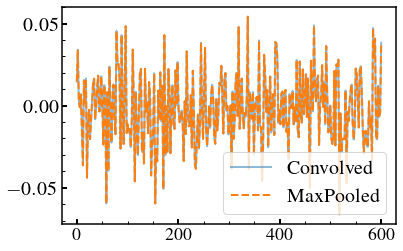

In [147]:
xt = x_test[0,:]
xt1 = x_test1[0,:,0]
xt2 = x_test2[0,0,:]
xt3 = x_test3[0,0,:]

import matplotlib.pyplot as plt

t = np.linspace(0,600,300)
# plt.plot(t,xt)
# plt.plot(t,xt1,'--')
plt.plot(t,xt2,alpha=0.5)
plt.plot(t,xt3,'--')
plt.legend(['Convolved','MaxPooled'])
plt.show()




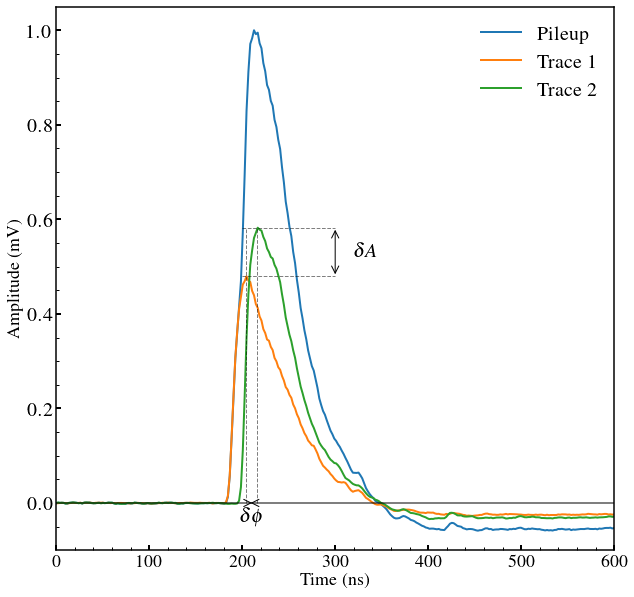

In [131]:
from matplotlib import pyplot as plt
params = {'axes.labelsize': 18,
                'axes.linewidth' : 1.5,
                'font.size': 18,
                'font.family': 'times',
                'mathtext.fontset': 'stix',
                'legend.fontsize': 20,
                'xtick.labelsize': 18,
                'ytick.labelsize': 20,
                'text.usetex': True,
                'lines.linewidth': 2,
                'lines.linestyle': '-',
                'lines.markersize' : 6,
                'lines.markeredgewidth' : 1,
                'xtick.major.size' : 5,
                'xtick.minor.size' : 3,
                'xtick.major.width' : 2,
                'xtick.minor.width' : 1,
                'xtick.direction' : 'in',
                'ytick.major.size' : 5,
                'ytick.minor.size' : 3,
                'ytick.major.width' : 2,
                'ytick.minor.width' : 1,
                'ytick.direction' : 'in',
                'xtick.minor.visible' : True,
                'ytick.minor.visible' : True,
                'savefig.transparent': True,
                'errorbar.capsize': 1.5,
                }
plt.rcParams.update(params)


import numpy as np
n = np.random.randint(0, len(x_trace))
ptrace = x_trace[n][0]
maxptrace = np.max(ptrace)
amp = y_amp[n]
phase = y_phase[n]
y1, y2 = y_trace[n]
# y1 = y1/np.max(y1)
# y2 = (y2/np.max(y2))
# y2 = y2*amp 



t = np.linspace(0, 600,300)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.plot(t, ptrace, label="Pileup")
ax.plot(t, y1, label="Trace 1")
ax.plot(t, y2, label="Trace 2")
ax.plot([2*np.argmax(y1), 2*np.argmax(y1)], [0,1.0*np.max([np.max(y1),np.max(y2)])], color="k", linestyle="--", alpha=0.5,linewidth=1.0)
ax.plot([2*np.argmax(y2), 2*np.argmax(y2)],[0,1.0*np.max([np.max(y1),np.max(y2)])], color="k", linestyle="--", alpha=0.5,linewidth=1.0)
ax.plot([200,300],[np.max(y1), np.max(y1)], color="k", linestyle="--", alpha=0.5,linewidth=1.0)
ax.plot([200,300],[np.max(y2), np.max(y2)], color="k", linestyle="--", alpha=0.5,linewidth=1.0)
ax.text((2*np.argmax(y1)+2*np.argmax(y2))/2, -0.05, r"$\delta\phi$", fontsize=20, ha="center", va="bottom")
ax.text(320, (np.max([np.max(y2),np.max(y1)])-np.min([np.max(y2),np.max(y1)]))/2+np.min([np.max(y2),np.max(y1)]), r"$\delta A$", fontsize=20, ha="left", va="center")
ax.annotate("", xy=(300, np.max(y1)), xytext=(300, np.max(y2)), arrowprops=dict(arrowstyle="<->", color="k", linewidth=1.0))
ax.annotate("", xy=(1.95*np.argmax(y2), 0), xytext=(2.05*np.argmax(y1), 0), arrowprops=dict(arrowstyle="<->", color="k", linewidth=1.0))
ax.plot([0, 600], [0.0, 0.0], color="k", linestyle="-", alpha=0.5)

ax.set_xlim(0, 600)
ax.set_ylim(-0.1, 1.05)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Amplitude (mV)")
# ax.set_title("Pileup and Traces")
ax.legend(frameon=False)
plt.show()



## **Sub modules training**
- ✅ Discrminator
- ✅ Classifier
- ✅ Phase 
- ✅ Amplitude

# __Discriminator__ (Done)

In [3]:
# Train Discriminator
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# output files
historyfile = "history/discriminator_initial_history.h5"

# Create model
model = keras.Sequential([
    pn.TraceDiscriminatorBase(name="discriminator_base"),
    pn.TraceDiscriminatorHead(name="discriminator_head")
])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train model
history = model.fit(x_trace, y_trace, epochs=500, batch_size=256, validation_split=0.2, verbose=1)
model.layers[0].save_weights(discriminator_base_weights)
model.layers[1].save_weights(discriminator_head_weights)
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(discriminator_initial_history, key="hist")

!cp -rf weights /content/drive/MyDrive/DeepLearningFinalProject/
!cp -rf history /content/drive/MyDrive/DeepLearningFinalProject/

Created 261852 samples: 50.17108901211371 % pileup, 49.82891098788629 % no pileup
Epoch 1/10
450/819 [===============>..............] - ETA: 39s - loss: 0.0041 - accuracy: 0.1582

KeyboardInterrupt: 

# __Classifier__ (Done)

In [ ]:
# Train Classifier
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
y_pileup = pn.EncodePileup(y_phase)
# Create model
model = keras.Sequential([
    pn.TraceClassifierBase(name="classifier_base"),
    pn.TraceClassifierHead(name="classifier_head")
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(x_trace, y_pileup, epochs=500, batch_size=128, validation_split=0.2, verbose=1)
model.layers[0].save_weights(classifier_base_weights)
model.layers[1].save_weights(classifier_head_weights)
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(classifier_initial_history, key="hist")

!cp -rf weights /content/drive/MyDrive/DeepLearningFinalProject/
!cp -rf history /content/drive/MyDrive/DeepLearningFinalProject/

# __Phase__ (Done)

In [ ]:
# Train Amplitude Regressor
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# Create model
model = keras.Sequential([
    pn.TraceAmplitudeRegressor(name = "amplitude_regressor")
])
model.compile(optimizer='adam', loss="mse", metrics=['accuracy'])

# Train model
history = model.fit(x_trace, y_amp, epochs=500, batch_size=128, validation_split=0.2, verbose=1)
model.layers[0].save_weights(amplitude_weights)
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(amplitude_initial_history, key="hist")

!cp -rf weights /content/drive/MyDrive/DeepLearningFinalProject/
!cp -rf history /content/drive/MyDrive/DeepLearningFinalProject/

# __Amplitude__ (Done)

In [ ]:
# Train Phase Regressor
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# Create model
model = keras.Sequential([
    pn.TracePhaseRegressor(name = "phase_regressor")
])
model.compile(optimizer='adam', loss="mse", metrics=['accuracy'])

# Train model
history = model.fit(x_trace, y_phase, epochs=500, batch_size=128, validation_split=0.2, verbose=1)
model.layers[0].save_weights(phase_weights)
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(phase_initial_history, key="hist")

!cp -rf weights /content/drive/MyDrive/DeepLearningFinalProject/
!cp -rf history /content/drive/MyDrive/DeepLearningFinalProject/

# **__Transfer and Fine-tuning__**
_____
* Transfer 1 (Direct)
* Transfer 2 (Long) 

In [3]:
input = layers.Input(shape=(1, 300))  # Returns a placeholder tensor
classifer_feature_vec = pn.TraceClassifierBase(name = "classifier_base")(input)
discriminator_feature_vec = pn.TraceDiscriminatorBase(name = "discriminator_base")(input)
trace_output = pn.TraceClassifierDiscriminatorHead(name = "transfer_head")([discriminator_feature_vec, classifer_feature_vec])
phase_output = pn.TracePhaseRegressor(name="phase_regressor")(trace_output)
amplitude_output = pn.TraceAmplitudeRegressor(name ="amplitude_regressor")(trace_output)
classifier_output = pn.TraceClassifierHead(name="classifier_head")(classifer_feature_vec)

## __Transfer 1 (Direct)__
* Transfer trace, phase and classifier onto new head
* Fine-tune model

#### Transfer

In [4]:
# load new data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# create model
model = models.Model(inputs=input, outputs=[trace_output, phase_output, amplitude_output])
model.compile(optimizer='adam', loss=['mse', 'mse', 'mse'], metrics=['accuracy'])
model_names = [model.layers[i].name for i in range(len(model.layers))]
# load weights
model.layers[model_names.index("discriminator_base")].load_weights(discriminator_base_weights)
model.layers[model_names.index("classifier_base")].load_weights(classifier_base_weights)
model.layers[model_names.index("phase_regressor")].load_weights(phase_weights)
model.layers[model_names.index("amplitude_regressor")].load_weights(amplitude_weights)
# freeze layers
model.layers[model_names.index("discriminator_base")].trainable = False
model.layers[model_names.index("classifier_base")].trainable = False
model.layers[model_names.index("phase_regressor")].trainable = False
model.layers[model_names.index("amplitude_regressor")].trainable = False                           
# print summary
model.summary()                                                         
# Train Discriminator Head
history = model.fit(x_trace, [y_trace, y_phase, y_amp], epochs=200, batch_size=128, validation_split=0.2, verbose=1)
# save weights
model.layers[model_names.index("transfer_head")].save_weights(transfer_head_weights)
# save model
model.save(transfer_model)
# save history
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(transfer_history, key="hist")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 300)]     0           []                               
                                                                                                  
 discriminator_base (TraceDiscr  (None, 2, 300)      992358      ['input_1[0][0]']                
 iminatorBase)                                                                                    
                                                                                                  
 classifier_base (TraceClassifi  (None, 1, 300)      244456      ['input_1[0][0]']                
 erBase)                                                                                          
                                                                                              

#### Fine-tune

In [ ]:
# load new data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# create model
model = models.Model(inputs=input, outputs=[trace_output, phase_output, amplitude_output])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=['mse', 'mse', 'mse'], metrics=['accuracy'])
model_names = [model.layers[i].name for i in range(len(model.layers))]
# load weights
model.layers[model_names.index("discriminator_base")].load_weights(discriminator_base_weights)
model.layers[model_names.index("classifier_base")].load_weights(classifier_base_weights)
model.layers[model_names.index("phase_regressor")].load_weights(phase_weights)
model.layers[model_names.index("amplitude_regressor")].load_weights(amplitude_weights)
model.layers[model_names.index("transfer_head")].load_weights(transfer_head_weights)                     
# print summary
model.summary()                                                         
# Train Discriminator Head
history = model.fit(x_trace, [y_trace, y_phase, y_amp], epochs=200, batch_size=128, validation_split=0.2, verbose=1)
# save weights
model.layers[model_names.index("discriminator_base")].save_weights(discriminator_base_fine_tuned_weights)
model.layers[model_names.index("classifier_base")].save_weights(classifier_base_fine_tuned_weights)
model.layers[model_names.index("phase_regressor")].save_weights(phase_fine_tuned_weights)
model.layers[model_names.index("amplitude_regressor")].save_weights(amplitude_fine_tuned_weights)
model.layers[model_names.index("transfer_head")].save_weights(transfer_head_fine_tuned_weights)
# save model
model.save(fine_tuned_model)
# save history
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(fine_tune_history, key="hist")

# __Transfer 2 (Long)__
* Transfer Trace onto head
* Transfer amplitude and phase onto head
* Fine tune


#### Transfer Trace

In [ ]:
# load new data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# create model
model = models.Model(inputs=input, outputs=trace_output)
model.compile(optimizer='adam', loss="mse", metrics=['accuracy'])
model_names = [model.layers[i].name for i in range(len(model.layers))]
# load weights
model.layers[model_names.index("discriminator_base")].load_weights(discriminator_base_weights)
model.layers[model_names.index("classifier_base")].load_weights(classifier_base_weights)
# freeze layers
model.layers[model_names.index("discriminator_base")].trainable = False
model.layers[model_names.index("classifier_base")].trainable = False                         
# print summary
model.summary()                                                         
# Train Discriminator Head
history = model.fit(x_trace,y_trace, epochs=200, batch_size=128, validation_split=0.2, verbose=1)
# save weights
model.layers[model_names.index("transfer_head")].save_weights(transfer_head_weights_trace)
# save history
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(transfer_history_trace, key="hist")

#### Fine Tune Phase

In [ ]:
input = layers.Input(shape=(1, 300))  # Returns a placeholder tensor
classifer_feature_vec = pn.TraceClassifierBase(name = "classifier_base")(input)
discriminator_feature_vec = pn.TraceDiscriminatorBase(name = "discriminator_base")(input)
trace_output = pn.TraceClassifierDiscriminatorHead(name = "transfer_head")([discriminator_feature_vec, classifer_feature_vec])
phase_output = pn.TracePhaseRegressor(name="phase_regressor")(trace_output)
amplitude_output = pn.TraceAmplitudeRegressor(name ="amplitude_regressor")(trace_output)
classifier_output = pn.TraceClassifierHead(name="classifier_head")(classifer_feature_vec)


x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# create model
model = models.Model(inputs=input, outputs=phase_output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse", metrics=['accuracy'])
model_names = [model.layers[i].name for i in range(len(model.layers))]
# load weights
model.layers[model_names.index("discriminator_base")].load_weights(discriminator_base_weights)
model.layers[model_names.index("classifier_base")].load_weights(classifier_base_weights)
model.layers[model_names.index("phase_regressor")].load_weights(phase_weights)
# model.layers[model_names.index("amplitude_regressor")].load_weights(amplitude_weights)
model.layers[model_names.index("transfer_head")].load_weights(transfer_head_weights_trace)
# freeze layers
model.layers[model_names.index("discriminator_base")].trainable = False
model.layers[model_names.index("classifier_base")].trainable = False
model.layers[model_names.index("transfer_head")].trainable = False
# model.layers[model_names.index("amplitude_regressor")].trainable = False                           
# print summary
model.summary()                                                         
# Train Discriminator Head
history = model.fit(x_trace, y_phase, epochs=200, batch_size=128, validation_split=0.2, verbose=1)
# save weights
model.layers[model_names.index("phase_regressor")].save_weights(phase_fine_tuned_weights_long_transfer)
# save history
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(fine_tuned_phase_long_transfer_history, key="hist")

###  FineTune Amplitude

In [ ]:
input = layers.Input(shape=(1, 300))  # Returns a placeholder tensor
classifer_feature_vec = pn.TraceClassifierBase(name = "classifier_base")(input)
discriminator_feature_vec = pn.TraceDiscriminatorBase(name = "discriminator_base")(input)
trace_output = pn.TraceClassifierDiscriminatorHead(name = "transfer_head")([discriminator_feature_vec, classifer_feature_vec])
phase_output = pn.TracePhaseRegressor(name="phase_regressor")(trace_output)
amplitude_output = pn.TraceAmplitudeRegressor(name ="amplitude_regressor")(trace_output)
classifier_output = pn.TraceClassifierHead(name="classifier_head")(classifer_feature_vec)


x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# create model
model = models.Model(inputs=input, outputs=amplitude_output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse", metrics=['accuracy'])
model_names = [model.layers[i].name for i in range(len(model.layers))]
# load weights
model.layers[model_names.index("discriminator_base")].load_weights(discriminator_base_weights)
model.layers[model_names.index("classifier_base")].load_weights(classifier_base_weights)
# model.layers[model_names.index("phase_regressor")].load_weights(phase_weights)
model.layers[model_names.index("amplitude_regressor")].load_weights(amplitude_weights)
model.layers[model_names.index("transfer_head")].load_weights(transfer_head_weights_trace)
# freeze layers
model.layers[model_names.index("discriminator_base")].trainable = False
model.layers[model_names.index("classifier_base")].trainable = False
model.layers[model_names.index("transfer_head")].trainable = False
# model.layers[model_names.index("amplitude_regressor")].trainable = False                           
# print summary
model.summary()                                                         
# Train Discriminator Head
history = model.fit(x_trace, y_amp, epochs=200, batch_size=128, validation_split=0.2, verbose=1)
# save weights
model.layers[model_names.index("amplitude_regressor")].save_weights(amplitude_fine_tuned_weights_long_transfer)
# save history
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(fine_tuned_amplitude_long_transfer_history, key="hist")

Save model

In [ ]:
input = layers.Input(shape=(1, 300))  # Returns a placeholder tensor
classifer_feature_vec = pn.TraceClassifierBase(name = "classifier_base")(input)
discriminator_feature_vec = pn.TraceDiscriminatorBase(name = "discriminator_base")(input)
trace_output = pn.TraceClassifierDiscriminatorHead(name = "transfer_head")([discriminator_feature_vec, classifer_feature_vec])
phase_output = pn.TracePhaseRegressor(name="phase_regressor")(trace_output)
amplitude_output = pn.TraceAmplitudeRegressor(name ="amplitude_regressor")(trace_output)
classifier_output = pn.TraceClassifierHead(name="classifier_head")(classifer_feature_vec)

model  = models.Model(inputs=input, outputs=[phase_output, amplitude_output, classifier_output])
model.compile(optimizer="adam", loss="mse", metrics=['accuracy'])
model_names = [model.layers[i].name for i in range(len(model.layers))]
# load weights
model.layers[model_names.index("discriminator_base")].load_weights(discriminator_base_weights)
model.layers[model_names.index("classifier_base")].load_weights(classifier_base_weights)
model.layers[model_names.index("phase_regressor")].load_weights(phase_fine_tuned_weights_long_transfer)
model.layers[model_names.index("amplitude_regressor")].load_weights(amplitude_fine_tuned_weights_long_transfer)
model.layers[model_names.index("transfer_head")].load_weights(transfer_head_weights_trace)
model.summary()
#save model
model.save(transfer_model_trace_transfer)

# __Control__
* Train whole network at once

In [ ]:
# load new data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# create model
model = models.Model(inputs=input, outputs=[trace_output, phase_output, amplitude_output])
model.compile(optimizer="adam",loss="mse", metrics=['accuracy'])
model_names = [model.layers[i].name for i in range(len(model.layers))]
# print summary
model.summary()
# train control model
history = model.fit(x_trace, [y_trace, y_phase, y_amp], epochs=400, batch_size=128, validation_split=0.2, verbose=1)
# save weights
model.layers[model_names.index("discriminator_base")].save_weights(discriminator_base_control_weights)
model.layers[model_names.index("classifier_base")].save_weights(classifier_base_control_weights)
model.layers[model_names.index("phase_regressor")].save_weights(phase_control_weights)
model.layers[model_names.index("amplitude_regressor")].save_weights(amplitude_control_weights)
model.layers[model_names.index("transfer_head")].save_weights(transfer_head_control_weights)
# save model
model.save(control_model)
# save history
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(control_history, key="hist")

# __Sequential Training__
* Train whole model on trace
* Train whole model on phase
* Train whole model on amplitude

In [3]:
# load new data
input = layers.Input(shape=(1, 300))  # Returns a placeholder tensor
discriminator_feature_vec = pn.TraceDiscriminatorBase(name = "discriminator_base")(input)
trace_output = pn.TraceDiscriminatorHead(name = "discriminator_head")(discriminator_feature_vec)
phase_output = pn.TracePhaseRegressor(name="phase_regressor")(trace_output)
amplitude_output = pn.TraceAmplitudeRegressor(name ="amplitude_regressor")(trace_output)

x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)

# Train Discriminator
# create model
model = models.Model(inputs=input, outputs=trace_output)
model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
model_names = [model.layers[i].name for i in range(len(model.layers))]
model.layers[model_names.index("discriminator_base")].load_weights(discriminator_base_weights)
model.layers[model_names.index("discriminator_head")].load_weights(discriminator_head_weights)
# print summary
model.summary()
# train model
history = model.fit(x_trace, y_trace, epochs=200, batch_size=128, validation_split=0.2, verbose=1)
# save weights
model.layers[model_names.index("discriminator_base")].save_weights(discriminator_base_sequential_weights)
model.layers[model_names.index("discriminator_head")].save_weights(discriminator_head_sequential_weights)
# save history
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(discriminator_sequential_history, key="hist")

# Train Phase Regressor
model = models.Model(inputs=input, outputs=phase_output)
model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
model_names = [model.layers[i].name for i in range(len(model.layers))]
model.layers[model_names.index("discriminator_base")].load_weights(discriminator_base_sequential_weights)
model.layers[model_names.index("discriminator_head")].load_weights(discriminator_head_sequential_weights)
model.layers[model_names.index("discriminator_base")].trainable = False
model.layers[model_names.index("discriminator_head")].trainable = False
# print summary
model.summary()
history = model.fit(x_trace, y_phase, epochs=700, batch_size=128, validation_split=0.2, verbose=1)
# save weights
model.layers[model_names.index("phase_regressor")].save_weights(phase_sequential_weights)
# save history
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(phase_sequential_history, key="hist")

# Train Amplitude Regressor
model = models.Model(inputs=input, outputs=amplitude_output)
model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
model_names = [model.layers[i].name for i in range(len(model.layers))]
model.layers[model_names.index("discriminator_base")].load_weights(discriminator_base_weights)
model.layers[model_names.index("discriminator_head")].load_weights(discriminator_head_sequential_weights)
model.layers[model_names.index("discriminator_base")].trainable = False
model.layers[model_names.index("discriminator_head")].trainable = False
# print summary
model.summary()
history = model.fit(x_trace, y_amp, epochs=700, batch_size=128, validation_split=0.2, verbose=1)
# save weights
model.layers[model_names.index("amplitude_regressor")].save_weights(amplitude_sequential_weights)
# save history
pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(amplitude_sequential_history, key="hist")

#save model
model = models.Model(inputs=input, outputs=[trace_output, phase_output, amplitude_output])
model.compile(optimizer="adam" loss='mse', metrics=['accuracy'])
model_names = [model.layers[i].name for i in range(len(model.layers))]
model.layers[model_names.index("discriminator_base")].load_weights(discriminator_base_weights)
model.layers[model_names.index("discriminator_head")].load_weights(discriminator_head_sequential_weights)
model.layers[model_names.index("phase_regressor")].load_weights(phase_sequential_weights)
model.layers[model_names.index("amplitude_regressor")].load_weights(amplitude_sequential_weights)

#save un tuned model
model.save(sequential_model)

# print summary
model.summary()

2023-05-11 00:02:14.787707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tmengel/root/lib
2023-05-11 00:02:14.787950: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-11 00:02:14.788069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tmengel): /proc/driver/nvidia/version does not exist
2023-05-11 00:02:14.790489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Created 261852 samples: 50.216534530956416 % pileup, 49.783465469043584 % no pileup
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 300)]          0         
                                                                 
 discriminator_base (TraceDi  (None, 2, 300)           992358    
 scriminatorBase)                                                
                                                                 
 discriminator_head (TraceDi  (None, 2, 300)           90450     
 scriminatorHead)                                                
                                                                 
Total params: 1,082,808
Trainable params: 1,082,808
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1637/1637 [==============================] - 177s 102ms/step - loss: 0.0031 - accuracy:

KeyboardInterrupt: 